In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import sys
sys.path.append('..')

from jax import numpy as jnp
import jax
import time
from scipy.integrate import quad, dblquad
import equinox as eqx
import jax_cosmo as jc
from quadax import quadgk, quadcc, quadts, romberg
from functools import partial

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation as animation 
from numpy import loadtxt
from diffrax import Kvaerno5, Tsit5
%matplotlib inline

from plot_params import params
#pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:

from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.reactions import Reaction
from linx.thermo import T_g 
from linx.const import mn, mp, eta0, hbar, me, aFS, NE_pd, NE_min, zeta_3
from scipy.integrate import odeint, solve_ivp, simpson, cumulative_simpson
from linx.pd_rates import decay_model
from linx.injected_spec import InjectedSpectrum, thermal_electron
eps = 1e-3
Emin = 1.5 # MeV
Ephb_T_max = 200

In [5]:
bkg_model = BackgroundModel()
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.), T_end = 1e-4, max_steps = 512*4)

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


/home/mkwok/miniconda3/envs/linx/lib/python3.13/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


In [6]:
InjSpec = InjectedSpectrum()

In [7]:
mod = decay_model(60, 1e5, 5e-7, 1, 0, t_vec, a_vec, rho_g_vec)

In [ ]:
(Tmin, Tmax) = mod.temperature_range()
T_grid = jnp.logspace(jnp.log10(Tmin), jnp.log10(Tmax), 50)

In [9]:
sp = InjSpec.get_spectrum(30, mod.get_source_0(), mod.get_source_cont(), 0.001)

Rate time:  1.6821143627166748
Kernel time:  2.3247857093811035
Source time:  0.324908971786499
Solve time:  0.03248119354248047


In [10]:
len(sp[0])

150

In [10]:
sp

Array([[1.50000000e+000, 2.09242619e+000, 2.91883158e+000,
        4.07162642e+000, 5.67971851e+000, 7.92292785e+000,
        1.10520945e+001, 1.54171280e+001, 2.15061349e+001,
        3.00000000e+001],
       [1.68949894e-025, 1.28165505e-025, 9.99621173e-026,
        7.48022998e-026, 4.48567290e-026, 1.65513679e-026,
        2.62552544e-027, 5.08798268e-030, 4.83065555e-033,
        1.00000000e-200],
       [1.50617916e-035, 9.23176810e-036, 5.88049898e-036,
        3.79516297e-036, 2.64227865e-036, 1.31346815e-036,
        4.08757923e-037, 4.49935453e-037, 6.21105146e-037,
        1.00000000e-200],
       [1.17740250e-037, 1.01786033e-037, 7.69052004e-038,
        1.67965155e-037, 7.10447572e-037, 6.39848408e-037,
        3.03651038e-037, 4.49716777e-037, 6.21104921e-037,
        1.00000000e-200]], dtype=float64)

#### Timing Progress

1m52s, 50F 10T

NEW: 34s, 50F 10T

2m12s 150F, 10T not bad

In [ ]:
mod.get_pdi_grids()
#1m52s, 50F 10T
#NEW: 34s, 50F 10T
#2m12s 150F, 10T not bad

Rate time:  0.028610944747924805
Kernel time:  3.754784107208252
Source time:  0.6633446216583252
Solve time:  0.0397944450378418


Array([[1.14776247e-004, 1.91458320e-004, 3.19371726e-004,
        5.32744148e-004, 8.88670799e-004, 1.48239224e-003,
        2.47277929e-003, 4.12484446e-003, 6.88065526e-003,
        1.14776247e-002],
       [1.00000000e-200, 1.61892607e-181, 1.06189870e-080,
        1.09591575e-044, 1.13947075e-031, 3.28184143e-027,
        5.33851805e-026, 2.13619857e-026, 3.19142924e-029,
        1.73490295e-031],
       [1.00000000e-200, 5.41967070e-183, 5.32807778e-082,
        6.83729658e-046, 4.46573274e-033, 1.69600912e-029,
        4.89875383e-031, 9.86081876e-033, 1.05872925e-033,
        2.03588490e-034],
       [1.00000000e-200, 2.41507626e-183, 1.45522570e-082,
        1.69998062e-046, 7.22322199e-034, 1.19345146e-031,
        8.39376610e-033, 1.07918677e-033, 2.58964073e-034,
        1.29579628e-035],
       [1.00000000e-200, 7.95643182e-183, 7.81155961e-082,
        9.85758185e-046, 7.11058360e-033, 4.65662869e-029,
        3.45152939e-030, 2.90531756e-032, 1.96615539e-033,
        3.6

In [ ]:
#5F, toT 26.3a
mod.get_pdi_grids()

Rate time:  0.6649606227874756
Kernel time:  1.5321593284606934
Source time:  0.040938377380371094
Solve time:  0.03774428367614746


Array([[1.14776247e-004, 1.26086430e-004, 1.38511131e-004,
        1.52160176e-004, 1.67154213e-004, 1.83625780e-004,
        2.01720474e-004, 2.21598240e-004, 2.43434784e-004,
        2.67423125e-004, 2.93775305e-004, 3.22724259e-004,
        3.54525877e-004, 3.89461261e-004, 4.27839219e-004,
        4.69998984e-004, 5.16313221e-004, 5.67191315e-004,
        6.23082995e-004, 6.84482305e-004, 7.51931973e-004,
        8.26028208e-004, 9.07425971e-004, 9.96844762e-004,
        1.09507498e-003, 1.20298492e-003, 1.32152843e-003,
        1.45175335e-003, 1.59481079e-003, 1.75196526e-003,
        1.92460592e-003, 2.11425878e-003, 2.32260026e-003,
        2.55147194e-003, 2.80289690e-003, 3.07909756e-003,
        3.38251535e-003, 3.71583228e-003, 4.08199463e-003,
        4.48423904e-003, 4.92612108e-003, 5.41154668e-003,
        5.94480667e-003, 6.53061471e-003, 7.17414894e-003,
        7.88109777e-003, 8.65771014e-003, 9.51085078e-003,
        1.04480609e-002, 1.14776247e-002],
       [1.000

: 

In [9]:
sp = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)
sp

Rate time:  3.7663016319274902
Kernel time:  22.082223176956177
Source time:  1.0649945735931396
Solve time:  0.19454717636108398


Array([[1.50000000e+000, 1.52363834e+000, 1.54764919e+000,
        1.57203843e+000, 1.59681201e+000, 1.62197600e+000,
        1.64753655e+000, 1.67349990e+000, 1.69987240e+000,
        1.72666051e+000, 1.75387077e+000, 1.78150983e+000,
        1.80958445e+000, 1.83810150e+000, 1.86706794e+000,
        1.89649086e+000, 1.92637746e+000, 1.95673503e+000,
        1.98757101e+000, 2.01889293e+000, 2.05070845e+000,
        2.08302534e+000, 2.11585151e+000, 2.14919499e+000,
        2.18306392e+000, 2.21746659e+000, 2.25241141e+000,
        2.28790692e+000, 2.32396180e+000, 2.36058486e+000,
        2.39778506e+000, 2.43557150e+000, 2.47395341e+000,
        2.51294018e+000, 2.55254133e+000, 2.59276656e+000,
        2.63362568e+000, 2.67512871e+000, 2.71728577e+000,
        2.76010719e+000, 2.80360342e+000, 2.84778511e+000,
        2.89266305e+000, 2.93824821e+000, 2.98455175e+000,
        3.03158498e+000, 3.07935940e+000, 3.12788669e+000,
        3.17717872e+000, 3.22724754e+000, 3.27810539e+00

In [9]:
mod.get_pdi_grids()

Rate time:  88.93914103507996
Kernel time:  5.150044918060303
Source time:  0.7670528888702393
Solve time:  0.20316243171691895


Array([[1.14776247e-004, 3.62954363e-004, 1.14776247e-003,
        3.62954363e-003, 1.14776247e-002],
       [1.00000000e-200, 6.86332516e-045, 1.34573165e-010,
        6.12208894e-025, 2.51574177e-032],
       [1.00000000e-200, 1.32141236e-061, 6.68228081e-025,
        1.67845057e-027, 6.18161511e-035],
       [1.00000000e-200, 7.68869731e-064, 1.50622983e-026,
        3.93009950e-030, 4.37809308e-036],
       [1.00000000e-200, 1.73995051e-061, 8.55362931e-025,
        3.06557734e-026, 1.04653054e-034],
       [1.00000000e-200, 7.36244202e-063, 6.28094976e-026,
        1.16656266e-029, 9.55833937e-036],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        2.94758663e-034, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        8.94341410e-035, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        1.00000000e-200

In [14]:
InjSpec = InjectedSpectrum()
sp = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)
sp

Rate time:  2.297499179840088
Kernel time:  2.350867986679077
Source time:  0.059534311294555664
Solve time:  0.02608489990234375


Array([[1.50000000e+00, 1.71470296e+00, 1.96013749e+00, 2.24070237e+00,
        2.56142599e+00, 2.92805649e+00, 3.34716475e+00, 3.82626220e+00,
        4.37393541e+00, 5.00000000e+00],
       [1.32969263e-22, 1.32020534e-23, 1.66258878e-24, 2.56649348e-25,
        4.61875947e-26, 9.01480951e-27, 1.66878927e-27, 2.14571914e-28,
        2.01231084e-29, 8.12899112e-30],
       [1.09418603e-29, 7.86041058e-30, 6.04605851e-30, 5.00134610e-30,
        4.40083128e-30, 4.03075787e-30, 3.77201155e-30, 3.60239403e-30,
        3.61213189e-30, 1.80442658e-40],
       [1.09392346e-29, 7.86013562e-30, 6.04602163e-30, 5.00134007e-30,
        4.40083016e-30, 4.03075765e-30, 3.77201151e-30, 3.60239402e-30,
        3.61213188e-30, 0.00000000e+00]], dtype=float64)

In [ ]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='pd_PRIMAT_2023', pd_model= mod)
)

nuclear_rates_q = jnp.zeros(12)

sol = abd_model(
    rho_g_vec, rho_nu_vec, 
    rho_NP_vec, p_NP_vec,
    t_vec=t_vec, a_vec=a_vec, 
    eta_fac = jnp.asarray(1.), 
    tau_n_fac = jnp.asarray(1.), 
    nuclear_rates_q = nuclear_rates_q,
    save_history=True, T_end = 1e-4, max_steps = 4096*2, solver = Kvaerno5())

new_abundances = jnp.array([sol.evaluate(t) for t in t_vec])


Compiling abundance model...


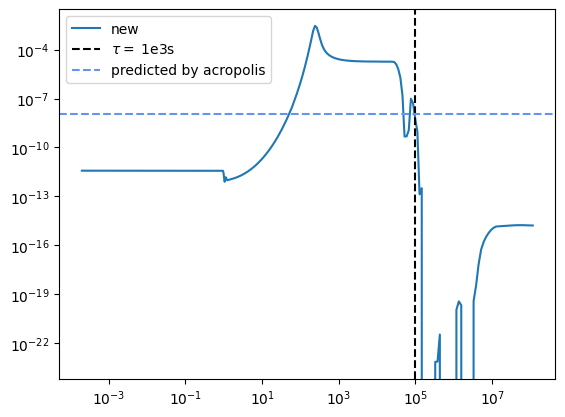

In [ ]:
first_nan = jnp.where(jnp.isnan(new_abundances[:, 2]))[0][0]
plt.plot(t_vec, new_abundances[:, 2], label = 'new')
#plt.plot(t_vec, rate_interp*1e-2)
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e5, label = r'$\tau = $ 1e3s', color = 'k', linestyle = '--')
#plt.axhline(2.527e-5*0.85122191, color = 'orange', linestyle = '--', label = 'observed abundance')
#plt.axhline(new_abundances[first_nan, 2], label = "linx", linestyle = '--', color = "k")
plt.axhline(1.190401e-08, color = 'cornflowerblue', linestyle = '--', label = 'predicted by acropolis')
#plt.ylim(1e-5, 3e-5)
#plt.xlim(1e3, 1e5)
plt.legend()

In [6]:
E_th = {
    "dgnp" :  2.224573,
    "tgnd" :  6.257248,
    "tgnpn" :  8.481821,
    "He3gpd" :  5.493485,
    "He3gnpp" :  7.718058,
    "He4gpt" : 19.813852,
    "He4gnHe3" : 20.577615,
    "He4gdd" : 23.846527,
    "He4gnpd" : 26.071100,
    "Li6gnpHe4" :  3.698892,
    "Li6gX" : 15.794685,
    "Li7gtHe4" :  2.467032,
    "Li7gnLi6" :  7.249962,
    "Li7gnnpHe4" : 10.948850,
    "Be7gHe3He4" :  1.586627,
    "Be7gpLi6" :  5.605794,
    "Be7gppnHe4" :  9.304680
}
Eth = jnp.array(list(E_th.values()))

In [9]:
mod = decay_model(60, 1e5, 5e-7, 1, 0, t_vec, a_vec, rho_g_vec)

In [45]:
one_temp = mod.pdi_rates(0.01)

Rate time:  0.7576980590820312
Kernel time:  0.08232736587524414
Source time:  0.34100818634033203
Solve time:  0.0002701282501220703
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
one_temp

Array([1.62126635e-031, 1.26432196e-034, 2.23008822e-035, 1.98244136e-034,
       3.30456598e-035, 1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
       1.00000000e-200, 5.72521642e-034, 1.00000000e-200, 1.84241416e-032,
       4.13957489e-035, 1.99624281e-037, 1.45502012e-031, 6.78428874e-035,
       9.95567288e-036], dtype=float64)

In [46]:
mod.get_pdi_grids()

Rate time:  25.03503108024597
Kernel time:  0.0765986442565918
Source time:  0.4944181442260742
Solve time:  2.3798279762268066


Array([[1.14740000e-004, 1.14741000e-003, 1.14740900e-002],
       [4.50857585e-171, 1.92696829e-024, 2.21035547e-032],
       [1.00000000e-200, 8.31709275e-195, 4.70787284e-035],
       [1.00000000e-200, 1.00000000e-200, 3.57636389e-036],
       [1.00000000e-200, 2.01931861e-163, 7.70738885e-035],
       [1.00000000e-200, 1.00000000e-200, 7.72426000e-036],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.27591862e-186, 2.00693150e-073, 2.11222790e-034],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.13285261e-172, 1.53033754e-025, 3.47897846e-033],
       [1.00000000e-200, 1.00000000e-200, 1.01421330e-035],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [3.91750920e-170, 3.32309864e-024, 3.23470800e-032],
       [1.00000000e-200, 1.35659858e-168

In [10]:
sp = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)

Rate time:  10.751144886016846
Kernel time:  3.599963426589966
Source time:  0.652592658996582
Solve time:  0.9867477416992188


In [43]:
def F_s(log_E, i):
    E = jnp.exp(log_E)
    #return jnp.interp(E, sp[0], sp[1]) * E * self.get_cross_section(E)[i]
    return jnp.exp(jnp.interp(jnp.log(E), jnp.log(sp[0]), jnp.log(sp[1]))) * E * mod.get_cross_section(E)[i]
def Fph_s(log_E):
    E = jnp.exp( log_E )
    
    return sp( ) * E * mod.get_cross_section(E)

In [35]:
def test_func(x):
    return (x[0], x[1])

In [38]:
jnp.transpose(jnp.array([jnp.log(Eth), jnp.full_like(Eth, jnp.log(1.6))]))[0]

Array([0.79956499, 0.47000363], dtype=float64)

In [22]:
for i in range(17):
    print(quadgk(F_s, [jnp.log(Eth[i]), jnp.log(1.6)], args = (i, )))

(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0., dtype=float64), QuadratureInfo(err=Array(0., dtype=float64), neval=Array(21, dtype=int64, weak_type=True), st

In [44]:
jax.vmap(quadgk, in_axes = (None, 1, 0) )(F_s, jnp.array([jnp.log(Eth), jnp.full_like(Eth, jnp.log(1.6))]), (jnp.arange(17), ))[0]

Array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.89722472e-49, 0.00000000e+00,
       0.00000000e+00], dtype=float64)

In [14]:
Fph_s(jnp.log(2))

TypeError: 'jaxlib.xla_extension.ArrayImpl' object is not callable

In [14]:
mod.get_pdi_grids()

Rate time:  41.81624913215637
Kernel time:  0.1351640224456787
Source time:  0.8743259906768799
Solve time:  0.001079559326171875
Traced<ShapedArray(float64[17])>with<BatchTrace(level=1/0)> with
  val = Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float64)
  batch_dim = 0


Array([[1.14740000e-004, 1.14741000e-003, 1.14740900e-002],
       [4.50858677e-171, 1.92697571e-024, 2.20792359e-032],
       [1.00000000e-200, 8.31796340e-195, 3.37904124e-035],
       [1.00000000e-200, 1.00000000e-200, 4.41640179e-037],
       [1.00000000e-200, 2.01931807e-163, 6.25798342e-035],
       [1.00000000e-200, 1.00000000e-200, 2.53245773e-036],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.27591801e-186, 1.93796087e-073, 1.82592244e-034],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.13287697e-172, 1.53033456e-025, 3.47889993e-033],
       [1.00000000e-200, 1.00000000e-200, 4.31301435e-036],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [5.64167969e-171, 1.70035284e-024, 1.78167387e-032],
       [1.00000000e-200, 1.35660009e-168

In [37]:
three_temps = mod.pdi_rates(jnp.array([3, 5, 7]))

ValueError: Cannot broadcast to shape with fewer dimensions: arr_shape=(3,) shape=()

In [18]:
three_temps.shape

(3, 17, 17)

In [20]:
%timeit mod.pdi_rates(5).block_until_ready()

Rate time:  0.03723478317260742
Kernel time:  0.010888099670410156
Source time:  0.07008218765258789
Solve time:  0.45337438583374023
1.54 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
mod.get_pdi_grids()

Rate time:  0.02277684211730957
Kernel time:  0.00667881965637207
Source time:  0.03879141807556152
Solve time:  0.0006124973297119141


Array([[[ 1.00000000e-200,  3.43127249e-205,  3.51403252e-205,
          9.91606351e-201,  3.93063246e-205,  3.94061182e-205,
          3.77551503e-205,  3.26610882e-208,  8.58355237e-208,
          1.00000000e-200,  8.48398439e-205,  1.00000000e-200,
          2.68999370e-205,  3.52584788e-205,  1.00000000e-200,
          3.59331057e-202,  3.84180383e-205],
        [ 4.72377576e-204,  3.47802983e-205,  3.51403696e-205,
          8.48814970e-205,  3.93063302e-205,  3.90767218e-205,
          3.80543704e-205,  3.26790560e-208,  8.56847225e-208,
          2.08542957e-204,  8.47972725e-205,  6.58403332e-205,
          2.69466562e-205,  3.52575071e-205,  0.00000000e+000,
          4.95690507e-205,  3.84179412e-205],
        [ 3.98360569e-205,  3.17616589e-205,  3.51403756e-205,
          3.23329868e-205,  3.92706317e-205,  3.90762114e-205,
          3.80542401e-205,  3.26792214e-208,  8.56837210e-208,
          6.58164268e-205,  8.47972537e-205,  2.59502293e-208,
          2.67945937e-205,

In [13]:
5 > jnp.array(list(E_th.values()))

Array([ True, False, False, False, False, False, False, False, False,
        True, False,  True, False, False,  True, False, False],      dtype=bool)

In [11]:
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(5), 5, base=jnp.e)
ii, jj = jnp.meshgrid(jnp.arange(3), E_grid, indexing='ij')

In [13]:
InjSpec.rate_x(ii.flatten(), jj.flatten(), jnp.full_like(jj.flatten(), 0.01))

Array([1.48929727e-17, 1.18140444e-15, 2.96468909e-14, 3.12209257e-13,
       1.72739024e-12, 2.84328170e-10, 2.78964054e-10, 2.66403186e-10,
       2.49423545e-10, 2.29960223e-10, 2.84328170e-10, 2.78964054e-10,
       2.66403186e-10, 2.49423545e-10, 2.29960223e-10], dtype=float64)

In [11]:
mod.pd_tables

Array([[1.14776247e-004, 1.14776247e-003, 1.14776247e-002],
       [1.00000000e-200, 1.00000000e-200, 6.19915177e-032],
       [1.00000000e-200, 1.00000000e-200, 7.88891194e-037],
       [1.00000000e-200, 1.00000000e-200, 3.06808952e-067],
       [1.00000000e-200, 1.00000000e-200, 1.18055298e-035],
       [1.00000000e-200, 1.00000000e-200, 1.08726449e-056],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 9.72145141e-035],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 1.13931006e-032],
       [1.00000000e-200, 1.00000000e-200, 1.22790384e-047],
       [1.00000000e-200, 1.00000000e-200, 1.00000000e-200],
       [1.00000000e-200, 1.00000000e-200, 6.53803418e-032],
       [1.00000000e-200, 1.00000000e-200

In [ ]:
dir(mod)

In [15]:
InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)

Rate time:  1.4310274124145508
Kernel time:  0.13996124267578125
Source time:  0.6634202003479004
Solve time:  0.0005469322204589844


Array([[1.50000000e+000, 2.02680023e+000, 2.73861279e+000,
        3.70041402e+000, 5.00000000e+000],
       [1.03519555e-022, 8.34928073e-025, 1.76063104e-026,
        3.79300659e-028, 8.12898254e-030],
       [6.00021510e-030, 3.07237428e-030, 2.40752876e-030,
        2.32581517e-030, 4.34857814e-191],
       [6.00021510e-030, 3.07237428e-030, 2.40752876e-030,
        2.32581517e-030, 4.34857814e-191]], dtype=float64)

In [ ]:
mod.get_pdi_grids()

In [ ]:
rates_i = mod.pdi_rates(0.01)
print(rates_i)

In [14]:
pdi_rates = jnp.array([[1.79507704e-180, 7.61656453e-183, 2.25062597e-184,
        1.81990493e-182, 5.23902999e-184, 1.00000000e-200,
        1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        6.22968129e-182, 2.01147832e-192, 6.30950360e-181,
        9.25721900e-184, 1.72201013e-186, 1.02890632e-180,
        5.85469164e-183, 6.08196967e-185],
       [3.32704835e-029, 6.88650382e-031, 3.72505336e-032,
        1.32219725e-030, 7.37756567e-032, 2.07791113e-037,
        5.42095241e-038, 3.89011243e-100, 5.87007179e-144,
        3.54311411e-030, 1.18925388e-035, 1.18740610e-029,
        1.13249292e-031, 8.19466752e-034, 1.44151709e-029,
        3.88415678e-031, 1.30078527e-032],
       [7.69015092e-032, 1.20633964e-034, 7.98129583e-036,
        2.11540830e-034, 1.76685100e-035, 1.00000000e-200,
        1.00000000e-200, 1.00000000e-200, 1.00000000e-200,
        5.94929745e-034, 1.00000000e-200, 1.30081174e-032,
        2.37792950e-035, 1.00000000e-200, 1.05423791e-031,
        6.06419952e-035, 8.96912718e-037]], dtype=float)

In [ ]:
mod.get_cross_sections(E_grid)

In [ ]:
T_range = mod.temperature_range()
print(T_range)
T_grid = jnp.linspace(T_range[0], T_range[1], 10)
T_grid

In [9]:
F_grid = InjSpec.get_spectrum(5, mod.get_source_0(), mod.get_source_cont(), 0.01)
print(F_grid)

KeyboardInterrupt: 

In [23]:
def F_s(log_E):
    E = jnp.exp(log_E)
    return jnp.exp(jnp.interp(jnp.log(E), jnp.log(F_grid[0]), jnp.log(F_grid[1]))) * E * mod.get_cross_section(E)


In [24]:
jax.vmap(quadgk, in_axes=(None, 0, None, None, None, None))(F_s, [jnp.log(Eth), jnp.full_like(Eth, jnp.log(200))], (), False, 0, eps,)

(Array([[5.75661445e-32, 4.78724821e-34, 5.16871323e-34, 5.31877511e-34,
         7.75789297e-34, 9.12597606e-34, 1.00511838e-33, 1.51393789e-36,
         1.90427992e-34, 9.54197677e-34, 1.38048594e-33, 5.16411415e-33,
         2.56851054e-34, 4.63427310e-34, 5.20672394e-32, 2.02389968e-34,
         4.29810951e-34],
        [6.83287665e-34, 4.78724185e-34, 5.16870498e-34, 5.30384414e-34,
         7.75789065e-34, 9.12582387e-34, 1.00510652e-33, 1.51392561e-36,
         1.90428138e-34, 9.42720195e-34, 1.38048472e-33, 5.46619965e-36,
         2.56832392e-34, 4.63427205e-34, 0.00000000e+00, 2.01630418e-34,
         4.29811463e-34],
        [5.98362672e-34, 4.64651690e-34, 5.16870959e-34, 5.05770217e-34,
         7.75499214e-34, 9.12587406e-34, 1.00510741e-33, 1.51392583e-36,
         1.90428109e-34, 8.92435475e-34, 1.38048524e-33, 2.10948961e-37,
         2.55584849e-34, 4.63427338e-34, 0.00000000e+00, 1.96011139e-34,
         4.29811471e-34],
        [7.17648126e-34, 4.78724167e-34, 5.168

In [ ]:
a = 5
def cond_fun(state):
  # Define the condition for the loop to continue
  return state[0] < 10

def body_fun(state):
  # Define the operations to perform in each iteration
  return (state[0] + 1, state[1]**2)

init_val = 0  # Initial value for the loop variable

final_state = jax.lax.while_loop(cond_fun, body_fun, (0, 5))

print(final_state)  # Output: 10

In [ ]:
S_0f, S_contf = mod.get_source_0(), mod.get_source_cont()

NE = jnp.array(jnp.log10(5/Emin)*150, int)
NE = jnp.maximum(NE, 150)
NE = 10

#number of species
N_X = 3

E_grid = jnp.logspace(jnp.log(Emin), jnp.log(5), NE, base=jnp.e)

# Generate the grid for the different species
X_grid = jnp.arange(N_X)

#rate (MeV)
R = jnp.array([[InjSpec.rate_x(X, E, 0.01) for E in E_grid] for X in X_grid])
#R = jnp.array([self.rate_x(X_grid, E, T) for E in E_grid])
ii, jj, kk, ll = jnp.meshgrid( X_grid, X_grid,E_grid, E_grid,indexing='ij')
k = jnp.stack([ll, kk, jj, ii], axis=-1)
k_true = jnp.array(k[:, :, :, :, 0] >= k[:, :, :, :, 1])
K = jnp.select([k_true], [jnp.array([[[[InjSpec.kernel_x(X, X_out, E, 0.01, Ep) for Ep in E_grid] for E in E_grid] for X_out in X_grid] for X in X_grid])])
S_0 = jnp.array([S0X(0.01) for S0X in S_0f])
S_cont = jnp.array([[SCX(E, 0.01) for E in E_grid] for SCX in S_contf])

In [28]:
from linx.injected_spec import set_spectra

In [ ]:

N_X = len(R)
NE = len(E_grid)

dy = jnp.log(E_grid[-1]/Emin)/(NE-1)

#create the grid to store the spectrums
#F_grid = jnp.zeros((N_X, NE)) 

#calculate the last row, which is important for trapezoidal rule
FX_E0 = jnp.array([S_cont[X,-1]/R[X,-1] + jnp.sum(K[X,:,-1,-1]*S_0[:]/(R[:,-1]*R[X,-1])) for X in range(N_X)])

#F_grid = set_spectra(F_grid, -1, FX_E0)
#i  = (NE - 1) - 1 # start at the second to last index, NE-2

def cond_func(i_vec):
    return i_vec[0] >= 0

#@partial(jax.jit, static_argnums=(0,))
def body_func(i_vec):
#while i >= 0: # Counting down
    i = i_vec[0]
    B = jnp.zeros( (N_X, N_X) )
    a = jnp.zeros( (N_X,   ) )

    I = jnp.identity(N_X)
    # Calculate the matrix B and the vector a
    for X in jnp.arange(N_X):
        # Calculate B, : <--> Xp
        B = B.at[X,:].set(-.5*dy*E_grid[i]*K[X,:,i,i] + R[X,i]*I[X,:])

        # Calculate a
        a = a.at[X].set(S_cont[X,i])
        for Xp in jnp.arange(N_X):
            a = a.at[X].add(K[X,Xp,i,-1]*S_0[Xp]/R[Xp,-1] + .5*dy*E_grid[-1]*K[X,Xp,i,-1]*i_vec[1][Xp,-1])
            for j in range(i, NE-1): # Goes from i+1 to NE-2
                a = a.at[X].add(dy*E_grid[j]*K[X,Xp,i,j]*i_vec[1][Xp,j])

    # Solve the system of linear equations of the form BF = a
    F_grid = set_spectra(i_vec[1], i,jnp.linalg.solve(B, a))

    return (i-1, F_grid)

F_grid = jax.lax.while_loop(cond_func, body_func, ((NE - 1) - 1, set_spectra(jnp.zeros((N_X, NE)), -1, FX_E0)))[1]

approx_zero = 1e-200
# Remove potential zeros
F_grid = F_grid.reshape( N_X*NE )
F_grid = F_grid.at[:].set(jnp.where(F_grid > approx_zero, F_grid, approx_zero))
#for i, f in enumerate(F_grid):
    #if f < approx_zero:
    #    F_grid[i] = approx_zero
#    F_grid.at[i].set(f < approx_zero, f, approx_zero)
F_grid = F_grid.reshape( (N_X, NE) )

# Define the output array...
sol = jnp.zeros( (N_X+1, NE) )
# ...and fill it
sol = sol.at[0     , :].set(E_grid)
sol = sol.at[1:N_X+1, :].set(F_grid)

sol


In [ ]:
body_func((NE - 1, set_spectra(jnp.zeros((N_X, NE)), -1, FX_E0)))

In [ ]:
jnp.arange(1, 3)

In [158]:
#@partial(jax.jit, static_argnums=0)
@jax.jit
def test_func(i):
    l = i[0] 
    for j in jnp.arange(l, 3):
        t = E_grid[j]
    return t


In [ ]:
test_func((0, E_grid))

In [ ]:
%timeit InjSpec.inverse_compton_kernel_photon(5, 0.01, 8)

In [ ]:
%timeit InjSpec.inverse_compton_kernel_photon(5, 0.01, 8)

In [28]:
print(Tmin, Tmax) 

0.00011477624731903082 0.011477624731903075


In [32]:
InjSpec.compton_scattering_kernel_photon(30, T_grid, 80)

Array([3.06035100e-29, 4.05714210e-29, 5.37859939e-29, 7.13047035e-29,
       9.45294558e-29, 1.25318774e-28, 1.66136523e-28, 2.20249077e-28,
       2.91986704e-28, 3.87090092e-28, 5.13169735e-28, 6.80314950e-28,
       9.01901262e-28, 1.19566075e-27, 1.58510105e-27, 2.10138648e-27,
       2.78583194e-27, 3.69320906e-27, 4.89612923e-27, 6.49085417e-27,
       8.60499914e-27, 1.14077452e-26, 1.51233774e-26, 2.00492333e-26,
       2.65794965e-26, 3.52367406e-26, 4.67137475e-26, 6.19289460e-26,
       8.20999075e-26, 1.08840781e-25, 1.44291460e-25, 1.91288828e-25,
       2.53593774e-25, 3.36192148e-25, 4.45693752e-25, 5.90861272e-25,
       7.83311504e-25, 1.03844496e-24, 1.37667829e-24, 1.82507806e-24,
       2.41952672e-24, 3.20759408e-24, 4.25234392e-24, 5.63738067e-24,
       7.47353962e-24, 9.90775642e-24, 1.31348253e-23, 1.74129872e-23,
       2.30845950e-23, 3.06035100e-23], dtype=float64)

In [45]:
print("Photon Rates Test")
print("---------------")
print("double photon", InjSpec.dphoton_pair_prod_rate(30, 0.001))
print("photonphoton", InjSpec.photon_photon_scattering_rate(30, 0.001))
print("BH", InjSpec.bethe_heitler_pair_prod_rate(30, 0.001), InjSpec.bethe_heitler_pair_prod_rate(3, 0.01), InjSpec.bethe_heitler_pair_prod_rate(5, 0.01))
print("CS", InjSpec.compton_scattering_rate(30, 0.001))
print("total", InjSpec.total_rate_photon(30, 0.001))
print()
print("Photon Kernel Test")
print("---------------")
print("photonphoton", InjSpec.photon_photon_scattering_kernel(30, 0.001, 80))
print("CS", InjSpec.compton_scattering_kernel_photon(30, 0.001, 80))
print("Inverse CS", InjSpec.inverse_compton_kernel_photon(30, 0.001, 80))
print("total", InjSpec.total_kernel_photon(30, 0.001, 80, 0), InjSpec.total_kernel_photon(30, 0.001, 80, 1), InjSpec.total_kernel_photon(30, 0.001, 80, 2))

Photon Rates Test
---------------
double photon 6.551955081159718e-17
photonphoton 2.2220094237233926e-21
BH 1.5185072536127578e-24 1.93931715860427e-22 4.226659078975712e-22
CS 7.40059115872738e-24
total 6.552178174011931e-17

Photon Kernel Test
---------------
photonphoton 7.283939142849162e-22
CS 2.0240217544628845e-26
Inverse CS 2.8922138870947667e-15
total 7.284141545024609e-22 2.8922138870947667e-15 2.8922138870947667e-15


In [23]:
print("Photon Rates Test")
print("---------------")
print("double photon", InjSpec.dphoton_pair_prod_rate(5, 0.01))
print("photonphoton", InjSpec.photon_photon_scattering_rate(5, 0.01))
print("BH", InjSpec.bethe_heitler_pair_prod_rate(1, 0.01), InjSpec.bethe_heitler_pair_prod_rate(3, 0.01), InjSpec.bethe_heitler_pair_prod_rate(5, 0.01))
print("CS", InjSpec.compton_scattering_rate(5, 0.01))
print("total", InjSpec.total_rate_photon(5, 0.01))
print()
print("Photon Kernel Test")
print("---------------")
print("photonphoton", InjSpec.photon_photon_scattering_kernel(5, 0.01, 8))
print("CS", InjSpec.compton_scattering_kernel_photon(5, 0.01, 8))
print("Inverse CS", InjSpec.inverse_compton_kernel_photon(5, 0.01, 8))
print("total", InjSpec.total_kernel_photon(5, 0.01, 8, 0), InjSpec.total_kernel_photon(5, 0.01, 8, 1), InjSpec.total_kernel_photon(5, 0.01, 8, 2))

Photon Rates Test
---------------
double photon 1.7273806782478688e-12
photonphoton 9.528579442514193e-18
BH 0.0 1.93931715860427e-22 4.226659078975712e-22
CS 2.7877735519401764e-20


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [34]:
print("Electron Rates Test")
print("---------------")
print("Inverse CS", InjSpec.inverse_compton_rate(30, 0.001))
print("total", InjSpec.total_lepton_rate(30, 0.001))
print()
print("Electron Kernels Test")
print("---------------")
print("Double photon", InjSpec.dphoton_pair_prod_kernel(30, 0.001, 80))
print("BH", InjSpec.bethe_heitler_pair_prod_kernel(30, 0.001, 80))
print("CS", InjSpec.compton_scattering_kernel_electron(30, 0.001, 80))
print("Inverse CS", InjSpec.inverse_compton_kernel_lepton(30, 0.001, 80))
print("total", InjSpec.total_kernel_electron(30, 0.001, 80, 0), InjSpec.total_kernel_electron(30, 0.001, 80, 1), InjSpec.total_kernel_electron(30, 0.001, 80, 2))

Electron Rates Test
---------------
Inverse CS 2.70270510818421e-13
total 2.70270510818421e-13

Electron Kernels Test
---------------
Double photon 2.3060755046227723e-16
BH 2.901980384627019e-26
CS 1.4794122448648354e-26
Inverse CS 1.6869299952434074e-15
total 2.3060755050609116e-16 1.6869299952434074e-15 0.0


In [ ]:
print("Positron Rates Test")
print("---------------")
print("Inverse CS", InjSpec.inverse_compton_rate(5, 0.01))
print("total", InjSpec.total_lepton_rate(5, 0.01))
print()
print("Positron Kernels Test")
print("---------------")
print("Double photon", InjSpec.dphoton_pair_prod_kernel(5, 0.01, 8))
print("BH", InjSpec.bethe_heitler_pair_prod_kernel(5, 0.01, 8))
print("CS", InjSpec.compton_scattering_kernel_electron(5, 0.01, 8))
print("Inverse CS", InjSpec.inverse_compton_kernel_lepton(5, 0.01, 8))
print("total", InjSpec.total_kernel_positron(5, 0.01, 8, 0), InjSpec.total_kernel_positron(5, 0.01, 8, 1), InjSpec.total_kernel_positron(5, 0.01, 8, 2))

In [8]:
print("Photon Rates Test NEW")
print("---------------")
print("double photon")
%timeit InjSpec.dphoton_pair_prod_rate(5, 0.01)
print("photonphoton")
%timeit InjSpec.photon_photon_scattering_rate(5, 0.01)
print("BH")
%timeit InjSpec.bethe_heitler_pair_prod_rate(1, 0.01)
print("CS")
%timeit InjSpec.compton_scattering_rate(5, 0.01)
print("total")
%timeit InjSpec.total_rate_photon(5, 0.01)
print()
print("Photon Kernel Test")
print("---------------")
print("photonphoton")
%timeit InjSpec.photon_photon_scattering_kernel(5, 0.01, 8)
print("CS")
%timeit InjSpec.compton_scattering_kernel_photon(5, 0.01, 8)
print("Inverse CS")
%timeit InjSpec.inverse_compton_kernel_photon(5, 0.01, 8)
print("total")
%timeit InjSpec.total_kernel_photon(5, 0.01, 8, 0)

Photon Rates Test NEW
---------------
double photon
2.26 s ± 442 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
photonphoton
258 μs ± 9.62 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
BH
258 μs ± 5.26 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
253 μs ± 3.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
total
16.2 ms ± 777 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Photon Kernel Test
---------------
photonphoton
250 μs ± 3.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
251 μs ± 3.06 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Inverse CS
377 μs ± 98.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
total
418 μs ± 110 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print("Photon Rates Test NEW")
print("---------------")
print("double photon")
%timeit InjSpec.dphoton_pair_prod_rate(5, 0.01)
print("photonphoton")
%timeit InjSpec.photon_photon_scattering_rate(5, 0.01)
print("BH")
%timeit InjSpec.bethe_heitler_pair_prod_rate(1, 0.01)
print("CS")
%timeit InjSpec.compton_scattering_rate(5, 0.01)
print("total")
%timeit InjSpec.total_rate_photon(5, 0.01)
print()
print("Photon Kernel Test")
print("---------------")
print("photonphoton")
%timeit InjSpec.photon_photon_scattering_kernel(5, 0.01, 8)
print("CS")
%timeit InjSpec.compton_scattering_kernel_photon(5, 0.01, 8)
print("Inverse CS")
%timeit InjSpec.inverse_compton_kernel_photon(5, 0.01, 8)
print("total")
%timeit InjSpec.total_kernel_photon(5, 0.01, 8, 0)

Photon Rates Test NEW
---------------
double photon
31.2 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
photonphoton
507 μs ± 8.55 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
BH
337 μs ± 101 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
229 μs ± 1.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
total
15.4 ms ± 335 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Photon Kernel Test
---------------
photonphoton
247 μs ± 8.41 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
252 μs ± 9.08 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Inverse CS
315 μs ± 7.15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
total
326 μs ± 8.11 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
print("Electron Rates Test NEW")
print("---------------")
print("Inverse CS")
%timeit InjSpec.inverse_compton_rate(5, 0.01)
print("total")
%timeit InjSpec.total_lepton_rate(5, 0.01)
print()
print("Electron Kernels Test")
print("---------------")
print("Double photon")
%timeit InjSpec.dphoton_pair_prod_kernel(5, 0.01, 8)
print("BH")
%timeit InjSpec.bethe_heitler_pair_prod_kernel(5, 0.01, 8)
print("CS")
%timeit InjSpec.compton_scattering_kernel_electron(5, 0.01, 8)
print("Inverse CS")
%timeit InjSpec.inverse_compton_kernel_lepton(5, 0.01, 8)
print("total")
%timeit InjSpec.total_kernel_electron(5, 0.01, 8, 0)

Electron Rates Test NEW
---------------
Inverse CS
17.2 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
total
17.1 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Electron Kernels Test
---------------
Double photon
377 μs ± 115 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
BH
230 μs ± 1.55 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
231 μs ± 1.13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Inverse CS
381 μs ± 109 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
total
453 μs ± 108 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print("Electron Rates Test")
print("---------------")
print("Inverse CS")
%timeit InjSpec.inverse_compton_rate(5, 0.01)
print("total")
%timeit InjSpec.total_lepton_rate(5, 0.01)
print()
print("Electron Kernels Test")
print("---------------")
print("Double photon")
%timeit InjSpec.dphoton_pair_prod_kernel(5, 0.01, 8)
print("BH")
%timeit InjSpec.bethe_heitler_pair_prod_kernel(5, 0.01, 8)
print("CS")
%timeit InjSpec.compton_scattering_kernel_electron(5, 0.01, 8)
print("Inverse CS")
%timeit InjSpec.inverse_compton_kernel_lepton(5, 0.01, 8)
print("total")
%timeit InjSpec.total_kernel_electron(5, 0.01, 8, 0)

Electron Rates Test
---------------
Inverse CS
21.6 ms ± 466 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
total
20.2 ms ± 718 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Electron Kernels Test
---------------
Double photon
387 μs ± 16 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
BH
295 μs ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CS
311 μs ± 25.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Inverse CS
355 μs ± 23.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
total
403 μs ± 24 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
print("Positron Rates Test")
print("---------------")
print("Inverse CS")
%timeit InjSpec.inverse_compton_rate(5, 0.01)
print("total")
%timeit InjSpec.total_lepton_rate(5, 0.01)
print()
print("Positron Kernels Test")
print("---------------")
print("Double photon")
%timeit InjSpec.dphoton_pair_prod_kernel(5, 0.01, 8)
print("BH")
%timeit InjSpec.bethe_heitler_pair_prod_kernel(5, 0.01, 8)
print("CS")
%timeit InjSpec.compton_scattering_kernel_electron(5, 0.01, 8)
print("Inverse CS")
%timeit InjSpec.inverse_compton_kernel_lepton(5, 0.01, 8)
print("total")
%timeit InjSpec.total_kernel_positron(5, 0.01, 8, 0)

In [ ]:
%timeit InjSpec.dphoton_pair_prod_rate(5, 0.01)

In [ ]:
InjSpec.dphoton_pair_prod_rate(5, 0.01)

In [ ]:
a = jnp.linspace(1, 10, 10)
a = jnp.where(a > 5, 0, a)
print(a)

In [ ]:
from scipy.integrate import dblquad, quad
from scipy.special import erf, jv


def h(t, z):
    return f(t) * g(z)


def f(t):
    return 0.5 * t * (erf(t - a) - 1) * jv(0, q * t)


def g(z):
    return math.exp(-((z - a) ** 2)/(2 * (s ** 2)))


def h1(z):
    return integral_of_f(z) * g(z)

def integral_of_f(z):
    return quad(f, 0, 2 * z)[0]  # here abserr is discarded


if __name__ == '__main__':
    a, q, s = 0, 2, 3  # set the constants

    result, abserr = dblquad(h, 0, 60, lambda z: 0, lambda z: 2 * z)
    print(f'result: {result}, abserr: {abserr}')

    result1 = quad(h1, 0, 60)[0]  # abserr here for result1 is not valid since abserr is already discarded in the function integral_of_f
    print(f'result1: {result1}')


In [11]:
@jax.jit
def f_thermal_photon_spec(ep, T):
    return (ep**2)/jnp.pi**2 * 1/(jnp.exp(ep/T) - 1)
#
@jax.jit
def dp_integrand(s, ep, T):
    s = jnp.exp(s)
    ep = jnp.exp(ep)
    b = jnp.sqrt(1 - (4*me**2)/s)
    dp_cross_section = jnp.pi * aFS**2 /(2*me**2) * (1-b**2) * ((3-b**4) * jnp.log((1+b)/(1-b)) - 2*b *(2-b**2))  
    return f_thermal_photon_spec(ep, T)/ep**2 * dp_cross_section * s *ep *s  

@jax.jit
def dphoton_pair_prod_rate(E, T):

    #Check if incoming energy is greater than me^2/(22T)
    #acropolis uses 50T for a smaller threshold
    """    if (type(E) != float) and (type(E) != int):
        E = jnp.where(E < (me**2)/(50*T), 0, E)
    else:
    """
    #if E < (me**2)/(50*T):
    #    return 0
    
    @jax.jit
    def inside_int(s):
        s = jnp.exp(s)
        b = jnp.sqrt(1 - (4*me**2)/s)
        dp_cross_section = jnp.pi * aFS**2 /(2*me**2) * (1-b**2) * ((3-b**4) * jnp.log((1+b)/(1-b)) - 2*b *(2-b**2))  
        return dp_cross_section * s *s  
    
    @jax.jit
    def integral_of_inside(ep):
        return quadgk(inside_int, [jnp.log(4*me**2), jnp.log(4*E *ep)], epsrel = eps/10, epsabs=0)[0]
    
    @jax.jit
    def outside_integral(ep, T):
        ep = jnp.exp(ep)
        return integral_of_inside(ep) * f_thermal_photon_spec(ep, T)/ep**2 *ep



    ep_ll = jnp.log((me**2)/E)
    ep_ul = jnp.log(Ephb_T_max*T)

    #I_dp_pp = dblquad(dp_integrand, ep_ll, ep_ul, lambda x: jnp.log(4*me**2), lambda x: jnp.log(4*E) + x, epsrel = eps, epsabs=0, args=(T,)) 
    I_dp_pp = quadgk(outside_integral, [ep_ll, ep_ul], epsrel = eps, epsabs=0, args=(T,))
    return 1/(8*E**2) * I_dp_pp[0]

In [97]:
@jax.jit
def icre_integrand(E_ph, ep, E, T):
    #equation B.23 in Hufnagel 2018
    F = F_func(E_ph, E, ep)
    return f_thermal_photon_spec(ep, T)/ep * F
@jax.jit
def F_func(E, Ep, ep):   
        """Function used for calculating rates and kernels related to inverse compton scattering 

        Parameters
        ----------
        E: float 
            Energy of outgoing particle (MeV)
        Ep: float 
            E', energy of incoming particle (MeV)
        ep: float
            epsilon, energy of thermal bath

        Returns
        -------
        float 
            F(E, E', epsilon), which is (dimensionless)
        """
        
        
        #should never happen if limits are right
        '''
        if not (ep <= E <= (4*ep*Ep**2)/(me**2 + 4*ep*Ep)):
            return 0
        '''
        
        G_ep = 4*ep*Ep/(me**2)
        q = E/(G_ep*(Ep-E))
        F = 2*q*jnp.log(q) + (1+2*q)*(1-q) + G_ep**2 * q**2 * (1 - q)/(2+2*G_ep*q)

        return F

@jax.jit
def inverse_compton_rate(E, T):
        """ 
        Inverse Compton Scattering Rate Eq. B.24 in Hufnagel 2018
        
        Parameters
        ----------
        E: float
            Energy of outgoing particle (MeV)
        T: float
            Temperature of the thermal bath (MeV)

        Returns
        -------
        float
            Gamma^IC_e+- (MeV)
            
        """
        @jax.jit
        def inside_int(E_ph, E, ep):
            return F_func(E_ph, E, ep)
        
        @jax.jit
        def integral_of_inside(ep, E):
            return quadgk(inside_int, [ep, 4*ep*E**2 /(me**2 + 4*ep*E)], epsrel = eps/10, epsabs=0, args = (E, ep))[0]

        @jax.jit
        def outside_integral(ep, T, E):
            return integral_of_inside(ep, E) * f_thermal_photon_spec(ep, T)/ep
        
        ep_ll = 0
        ep_ul = jnp.minimum(E - (me**2)/(4*E), Ephb_T_max*T)
        #E_ph_ll = lambda x: x
        #E_ph_ul = lambda x: 4*x*E**2 /(me**2 + 4*x*E)

        #return 2*jnp.pi*aFS**2 /E**2 * dblquad(icre_integrand, ep_ll, ep_ul, E_ph_ll, E_ph_ul,  epsrel=eps, epsabs=0, args=(E, T))[0]
        return 2*jnp.pi*aFS**2 /E**2 * quadgk(outside_integral, [ep_ll, ep_ul], epsrel=eps, epsabs=0, args=(T, E))[0]

#@jax.jit
def inverse_compton_rate_vmap(E, T):
        """ 
        Inverse Compton Scattering Rate Eq. B.24 in Hufnagel 2018
        
        Parameters
        ----------
        E: float
            Energy of outgoing particle (MeV)
        T: float
            Temperature of the thermal bath (MeV)

        Returns
        -------
        float
            Gamma^IC_e+- (MeV)
            
        """
        @jax.jit
        def inside_int(E_ph, E, ep):
            return F_func(E_ph, E, ep)
        
        @jax.jit
        def integral_of_inside(ep, E):
            I_i =  jax.vmap(quadgk, in_axes=(None, 0, 1, None, None, None))(inside_int, [ep, 4*ep*E**2 /(me**2 + 4*ep*E)], jnp.array((E, ep)), False, 0,  eps)
            return I_i[0]
        @jax.jit
        def outside_integral(ep, T, E):
            return integral_of_inside(ep, E) * f_thermal_photon_spec(ep, T)/ep
        
        
        ep_ul = jnp.minimum(E - (me**2)/(4*E), Ephb_T_max*T)
        ep_ll = jnp.zeros_like(ep_ul)
        #E_ph_ll = lambda x: x
        #E_ph_ul = lambda x: 4*x*E**2 /(me**2 + 4*x*E)

        #return 2*jnp.pi*aFS**2 /E**2 * dblquad(icre_integrand, ep_ll, ep_ul, E_ph_ll, E_ph_ul,  epsrel=eps, epsabs=0, args=(E, T))[0]
        I =  2*jnp.pi*aFS**2 /E**2 * jax.vmap(quadgk, in_axes=(None, 0, 0, None, None, None))(outside_integral, [ep_ll, ep_ul], jnp.array((T, E)), False, 0, eps)
        return I[0]

In [98]:
def printing(a, b, c, d, e):
    return (a, b, c, d, e)

In [ ]:
jax.vmap(printing, in_axes=[0, 1, None, None, 0])(jnp.arange(5), jnp.zeros((2, 5)), 0, 0, jnp.arange(5))

In [ ]:
import time
test_energies = jnp.linspace(1, 10, 10)
inverse_compton_rate_vmap(test_energies, jnp.full_like(test_energies, 0.01))
start = time.time()
print("hello")
end = time.time()
print(end - start)

In [9]:
@jax.jit
def loopfunc(E_list):
    for E_i in E_list:
        print(inverse_compton_rate(E_i, 0.01))

In [ ]:
start = time.time()
loopfunc(test_energies)
end = time.time()
print("time", end - start)

In [16]:
X_grid = jnp.arange(3)
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(5), 50, base=jnp.e)
x1, x2 = jnp.meshgrid(X_grid, E_grid, indexing='ij')



In [ ]:
x1.flatten()

In [ ]:
x2.flatten()

In [ ]:
jax.vmap(InjSpec.rate_x, in_axes=(0, 0, None))(x1.flatten(), x2.flatten(), 0.01) 

In [ ]:
jnp.array([[InjSpec.rate_x(X, E, 0.01) for E in E_grid] for X in X_grid])

In [118]:
ii, jj, kk, ll = jnp.meshgrid( X_grid, X_grid,E_grid, E_grid,indexing='ij')

In [160]:
a =  jax.vmap(InjSpec.kernel_x, in_axes=(0, 0, 0, None, 0))(ii.flatten(), jj.flatten(), kk.flatten(), 0.01, ll.flatten())
a = jnp.reshape(a, (3, 3, 10, 10))
a = jnp.nan_to_num(a)


In [161]:
b = jnp.array([[[[InjSpec.kernel_x(X, X_out, E, 0.01, Ep) for Ep in E_grid] for E in E_grid] for X_out in X_grid] for X in X_grid])
b = jnp.nan_to_num(b)

In [ ]:
%timeit jax.vmap(InjSpec.rate_x, in_axes=(0, 0, None))(x1.flatten(), x2.flatten(), 0.01) 

In [ ]:
inverse_compton_rate(test_energies, 0.01)

In [ ]:
start = time.time()
print(jax.vmap(inverse_compton_rate, in_axes = (0, None))(test_energies, 0.01))
end = time.time()
print("time", end - start)

In [ ]:
%timeit loopfunc(test_energies)

In [ ]:
%timeit print(jax.vmap(inverse_compton_rate, in_axes = (0, None))(test_energies, 0.01))

In [ ]:
dphoton_pair_prod_rate(5, 0.01)

In [ ]:
%timeit dphoton_pair_prod_rate(5, 0.01)

In [ ]:
%timeit dphoton_pair_prod_rate(5, 0.01)

In [ ]:
%timeit dphoton_pair_prod_rate(5, 0.01)

In [ ]:
def test_func(x, y, z):
    return x*y

dblquad(test_func, 0, 1, lambda x: 0, lambda x: 4.*x , args=(2, ))

In [85]:
from quadax import quadgk, quadcc, quadts, romberg

In [11]:
gaussian = lambda x: 1/jnp.sqrt(jnp.pi) * jnp.exp(-x**2)

In [ ]:
quadgk(gaussian, [0, 1])

In [ ]:
%timeit quadgk(gaussian, [0, 1])

In [ ]:
%timeit quadcc(gaussian, [0, 1])

In [ ]:
%timeit quadts(gaussian, [0, 1])

In [ ]:
%timeit quad(gaussian, 0, 1)

In [ ]:
%timeit romberg(gaussian, [0, 1])

In [ ]:
%timeit jc.scipy.integrate.romb(gaussian, 0, 1)

In [ ]:
inverse_compton_rate(3, 0.01)

In [ ]:
inverse_compton_rate(3, 0.01)

In [ ]:
inverse_compton_rate(3, 0.01)

In [9]:
def photon_photon_scattering_rate(E, T):

    exp_fac = jnp.exp(-E*T/me**2)

    return 15568*(jnp.pi**3)/(3189375) * aFS**4 * me * (E/me)**3 * (T/me)**6 * exp_fac


In [10]:
import math
import time

In [11]:
def _rate_photon_photon( E, T):
    #if E > me2/T:
    #    return 0.
    expf = math.exp( -E*T/me**2 )

    return 0.151348 * (aFS**4.) * me * (E/me)**3. * (T/me)**6. * expf

@jax.jit
def photon_photon_scattering_rate_jit(E, T):

    exp_fac = jnp.exp(-E*T/me**2)

    return 15568*(jnp.pi**3)/(3189375) * aFS**4 * me * (E/me)**3 * (T/me)**6 * exp_fac

@jax.jit
def photon_photon_scattering_rate_lax(E, T):

    exp_fac = jax.lax.exp(-E*T/me**2)

    return 15568*(jnp.pi**3)/(3189375) * aFS**4 * me * (E/me)**3 * (T/me)**6 * exp_fac


In [23]:
start = time.time()
#for i in range(10000):
photon_photon_scattering_rate_lax(jnp.full((1000), 5), jnp.full((1000), 0.01))
end = time.time()
print(end-start)

0.0010564327239990234


In [24]:
start = time.time()
#for i in range(10000):
photon_photon_scattering_rate_jit(jnp.full((1000), 5), jnp.full((1000), 0.01))
end = time.time()
print(end-start)

0.0011553764343261719


In [29]:
n = 100
start = time.time()
#for i in range(10000):
jax.vmap(photon_photon_scattering_rate_jit, in_axes=(0, 0))(jnp.full((n), 5), jnp.full((n), 0.01))
end = time.time()
print(end-start)

0.0018115043640136719


In [30]:
start = time.time()
for i in range(n):
    _rate_photon_photon(5, 0.01)
end = time.time()
print(end-start)

0.0001862049102783203
